Adapted from: https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/hierarchical.ipynb

In [1]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
random.seed(1)

Basic HLM
===

In [153]:
# Set up basic parameters
n_markets = 4
no_permarket = 30
n_observed = no_permarket * n_markets
n_predictors = 3

In [154]:
n_observed

120

In [155]:
# Set up markets
market = concatenate([[i] * no_permarket for i in range(n_markets)])

# Simulate the features
predictors = random.normal(size=(n_observed, n_predictors))

In [156]:
market

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3])

In [157]:
# Choose random values to represent the actual alphas and betas
alpha_a = random.normal(size=(n_markets))
beta_a = random.normal(size=(n_markets, n_predictors))

In [158]:
alpha_a

array([ 1.3003868 , -1.17308246, -1.51934755, -0.47345498])

In [159]:
beta_a

array([[ 0.96915384,  1.38216889,  0.04525247],
       [-1.35192816, -1.55741915, -0.11053436],
       [-0.48653728, -1.65260647, -0.60129154],
       [ 0.24645532,  0.96409324,  0.7954797 ]])

In [169]:
# Calculate the actual data, but put a bit of noise in
y = alpha_a[market] + nsum(beta_a[market] * predictors, 1) + random.normal(size=(n_observed))

In [171]:
y.shape

(120,)

In [142]:
predictors.shape

(120, 3)

In [177]:
# Set up the PyMC model
model = Model()
with model:
    
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = Normal(b"mu_alpha", 0, 10, shape=(1))
    sigma_alpha = Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = Normal(b"mu_beta", 0, 10, shape=(1))
    sigma_beta = Uniform(b"sigma_beta", .0, 10, testval=2.)
    
    # Simulate the alphas
    alpha = Normal(b"alpha", mu_alpha, sigma_alpha, shape=(n_markets))
    
    # Simulate the betas
    beta = Normal(b'beta', mu_beta, sigma_beta, shape=(n_markets, n_predictors))
    
    m = T.constant(market)
    
    # Simulate the noise
    s = Uniform(b"s", .01, 10, shape=n_markets)

    yd = Normal(b'y', alpha[m] + sum(beta[m] * predictors, 1), s[m] ** -2, observed=y)

    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = NUTS()

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval to model.
(4,)
(4, 3)
(120,)
Applied interval-transform to s and added transformed s_interval to model.
(120, 3)


In [178]:
# Actually sample the model
tr = sample(3e4, step, model=model)

 [-----------------100%-----------------] 30000 of 30000 complete in 341.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2be9279890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2be8992350>]], dtype=object)

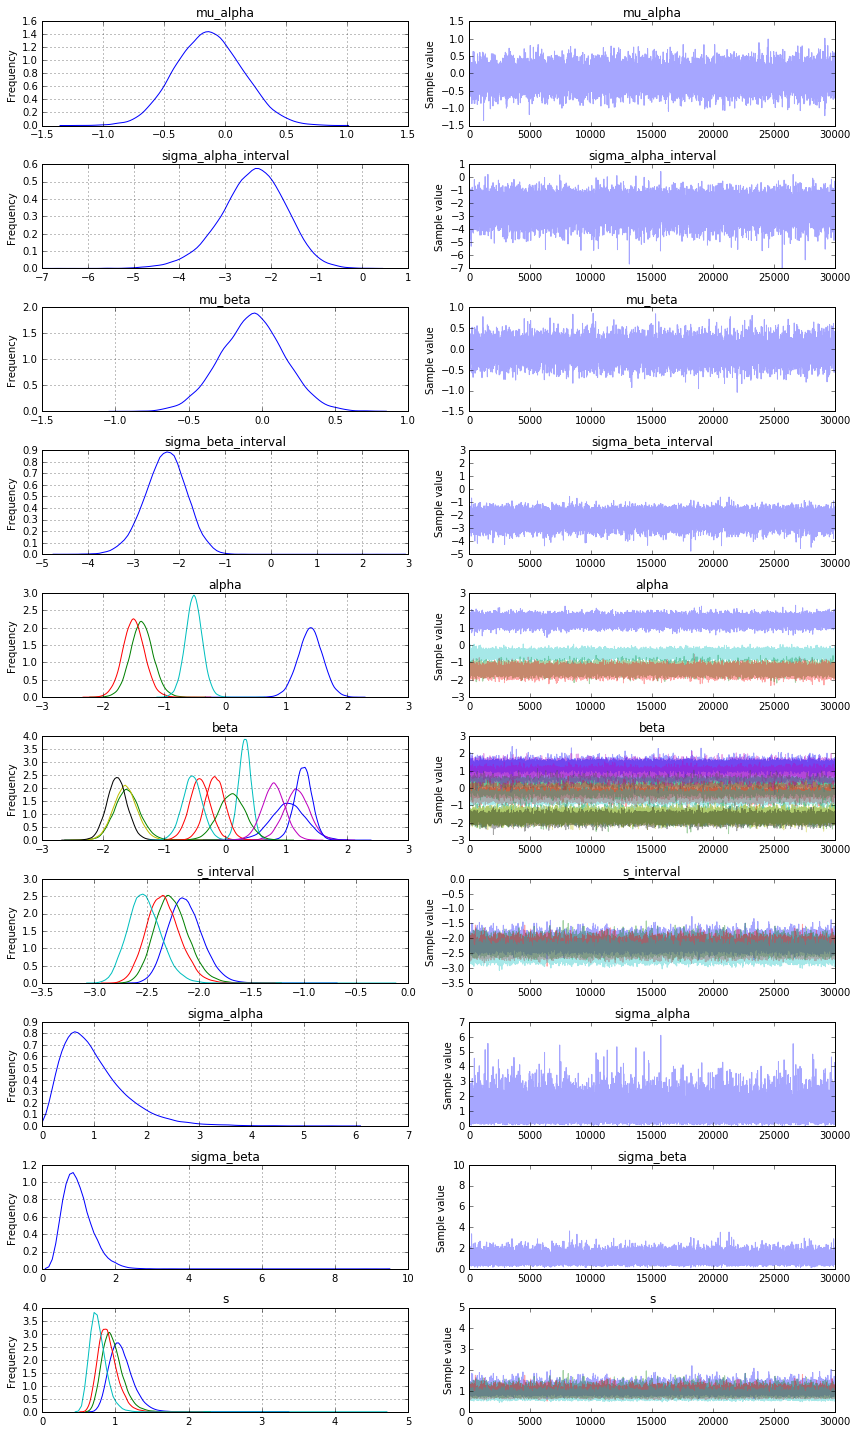

In [180]:
# Plot the variables
traceplot(tr)

In [181]:
# See a summary
summary(tr)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.131           0.276            0.003            [-0.657, 0.414]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.655         -0.320         -0.134         0.055          0.417


sigma_alpha_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.394           0.724            0.006            [-3.897, -1.059]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.936         -2.842         -2.356         -1.902         -1.084


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -

In [182]:
alpha_a

array([ 1.3003868 , -1.17308246, -1.51934755, -0.47345498])

In [183]:
beta_a

array([[ 0.96915384,  1.38216889,  0.04525247],
       [-1.35192816, -1.55741915, -0.11053436],
       [-0.48653728, -1.65260647, -0.60129154],
       [ 0.24645532,  0.96409324,  0.7954797 ]])